# 1.&nbsp;Objectives and Approach

The objective of this notebook is to demonstrate how quality engineering practitioners and researchers can utilize and adapt OpenAI's [CLIP model](https://openai.com/research/clip) for defect detection and image classification tasks. CLIP (Contrastive Language–Image Pretraining) is a neural network designed to associate images and text, enabling cross-modal understanding. This model is particularly powerful in applications where annotated datasets are scarce, as it uses contrastive learning to generalize from relatively few labeled examples.

![CLIP Model Architecture](https://github.com/openai/CLIP/raw/main/CLIP.png)

*Figure: CLIP's model architecture (Source: [OpenAI](https://github.com/openai/CLIP/blob/main/CLIP.png))*



The CLIP model architecture, shown above, uses two separate neural networks to encode images and text into a shared feature space, making it highly effective in tasks like image-text matching and retrieval. By leveraging CLIP's ability to match images with textual descriptions, this notebook provides a framework for quality engineers to classify images as "Defective" or "Nominal (No Defect)" based on a few-shot learning approach. The dataset used in this example is from [Megahed and Camelio (2012)](https://link.springer.com/content/pdf/10.1007/s10845-010-0378-3.pdf).

## Adapting CLIP for Few-Shot Learning in Quality Engineering

In this notebook, we’ve adapted CLIP to perform **few-shot learning** for quality inspection by:
1. **Using Image-Text Embeddings**: Instead of fine-tuning CLIP with a large, labeled dataset, we leverage its pre-trained image and text embeddings. This allows us to classify images as "Defective" or "Nominal" based on their similarity to a few reference examples.
2. **Few-Shot Classification Approach**:
   - We compute feature vectors (embeddings) for a few nominal and defective images, representing each class with minimal labeled data.
   - For each test image, we calculate its similarity to these pre-defined class embeddings, converting similarity scores into probabilities for each class (Defective vs. Nominal).
   - This approach allows CLIP to classify images effectively without requiring extensive training data, making it suitable for quality engineering applications where data labeling is limited or costly.

The notebook includes detailed functions to:
- **Load images from both local storage and online sources (such as GitHub)**, providing flexibility for diverse data sources.
- **Process and classify images using CLIP's pre-trained features** to identify similarities between test images and known examples of defective or nominal images.
- **Log classification results and probabilities** to a CSV file, creating a documented record for further analysis.

The intent of this notebook is to enable quality engineering professionals to apply this advanced model to their unique scenarios, whether in manufacturing, visual inspection, or other quality assurance applications. **Researchers can adapt and build upon the functions here to extend CLIP's capabilities via few-shot learning, exploring the model's robustness and effectiveness in recognizing nuanced defects.** *This can be easily done by changing the input images that we included in our quick analysis.*


# 2.&nbsp; Setup for Our Classification Experiments


## 2.1. Library Imports, OpenAI API Key, and Save Folder Location

This section imports all necessary libraries and checks if they are already installed in the Colab environment. If a package is missing, it installs it automatically.

**An Overview of the Loaded Libraries:**
*   `os` and `io`: Used for handling file paths and in-memory data respectively.
*   `csv`: To write classification results to a CSV file.  
*   `datetime`: Records the date and time of each operation.  
*   `requests`, `PIL`, `torch`, and `clip`: Handle image processing and loading the CLIP model.  

**Setting the API Key:**  
The code accesses the OpenAI API key, allowing the model to authenticate and function correctly. This is saved as a secret in Google Colab. To run the code, you must perform the following:  
*   Create an account and a secret key at the [OpenAI Platform](https://platform.openai.com/organization/api-keys).  
*   Copy the created key and store it in your Google Colab. This should be stored with the name `OPENAI_API_KEY` under *Secrets*, which is accessible at the left of your screen by clicking on the *key* icon.  

**Setting a Save Folder:**  
We also set a `save_folder` to automatically save the results to our Google Drive. **You will need to change the `save_folder` path to where you want to save it on your *Google Drive*. Otherwise, please comment our `save_folder` path and set `save_folder = '/content'`.

**Runtime:**

Depending on your selected Runtime, the code detects whether a GPU is available and, if so, assigns it for faster processing. Otherwise, it defaults to using the CPU. We used a CPU in our experiments (i.e., the least capable of Colab setups that is available to all users).

In [1]:
import os
from io import BytesIO
import importlib.util
import subprocess
import csv
from urllib.parse import urlparse
from IPython.display import Image as IPyImage, display, clear_output
import time
import json
import random

# packages that need to be installed in the colab
packages = ['openai', 'torch', 'pillow', 'requests', 'clip', 'datetime', 'matplotlib', 'pandas', 'sklearn', 'seaborn', 'numpy', 'typing']

# installing the packages if needed
for package in packages:
  spec = importlib.util.find_spec(package)
  if spec is None:
    print(f"Installing {package}...")
    subprocess.check_call(['pip', 'install', package])
    if package == 'clip':  # Special case for CLIP from GitHub
      subprocess.check_call(['pip', 'install', 'git+https://github.com/openai/CLIP.git'])
  else:
    print(f"{package} already installed.")

# importing those packages
import requests
from PIL import Image
import openai
import clip
import torch
import pandas as pd
import seaborn as sns
import numpy as np

# importing specific functions/modules from those libraries
from typing import List, Optional, Union, Any
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# package for importing our hidden key
from google.colab import userdata # if you are using colab
openai.api_key = userdata.get('OPENAI_API_KEY') # otherwise remove previous line and insert your key here

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-L/14", device=device)

# save folder
from google.colab import drive
drive.mount('/content/drive')
save_folder = '/content/drive/MyDrive/Miami/Code/GitHub/qe_genai/results'

# if you do not want to save to your google drive, please comment the above line
# and uncomment the line below
# save_folder = '/content'

openai already installed.
torch already installed.
Installing pillow...
requests already installed.
Installing clip...
datetime already installed.
matplotlib already installed.
pandas already installed.
sklearn already installed.
seaborn already installed.
numpy already installed.
typing already installed.


100%|███████████████████████████████████████| 890M/890M [01:01<00:00, 15.2MiB/s]


Mounted at /content/drive


## 2.2. Custom Functions

In the subsections below, we define multiple custom functions to facilitate our analysis.

### 2.2.1. Extract Image URLs from GitHub

In [2]:
import requests
from typing import List, Optional

def get_image_urls(
    repo_owner: str,
    repo_name: str,
    base_path: str,
    subfolder: str,
    branch: str = "main",
    file_extensions: Optional[List[str]] = None
) -> List[str]:
    """
    Retrieve the URLs of files in a specified GitHub repository subfolder.

    Parameters:
    - repo_owner (str): Owner of the GitHub repository.
    - repo_name (str): Name of the GitHub repository.
    - base_path (str): Path within the repository to the folder containing subfolder(s).
    - subfolder (str): Specific subfolder to retrieve file URLs from.
    - branch (str, optional): Branch to pull files from. Default is 'main'.
    - file_extensions (Optional[List[str]], optional): List of file extensions to filter by (e.g., ["jpg", "png"]).
      If None, returns all files.

    Returns:
    - List[str]: List of raw GitHub URLs to the files within the specified subfolder.
    """
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{base_path}/{subfolder}?ref={branch}"

    # Attempt to fetch data from the GitHub API
    try:
        response = requests.get(api_url)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Failed to retrieve files for {subfolder}. Error: {e}")
        return []

    # Filter and collect raw file URLs
    image_urls = []
    for file_info in response.json():
        if file_info['type'] == 'file':
            file_name = file_info['name']

            # Check if the file extension matches if specified
            if file_extensions is None or any(file_name.lower().endswith(ext.lower()) for ext in file_extensions):
                raw_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{base_path}/{subfolder}/{file_name}"
                image_urls.append(raw_url)

    return image_urls


### 2.2.2. Load Image

In [3]:
from typing import Union
from PIL import Image
import requests
from urllib.parse import urlparse
from io import BytesIO

def load_image(image_path_or_url: str, mode: str = "RGB") -> Image.Image:
    """
    Load an image from a local file path or a URL.

    Parameters:
    - image_path_or_url (str): The local file path or URL of the image.
    - mode (str, optional): Mode to convert the image to (e.g., "RGB", "L" for grayscale).
      Default is "RGB".

    Returns:
    - Image.Image: The loaded PIL image object in the specified mode.

    Raises:
    - ValueError: If the input is not a valid URL or file path.
    - IOError: If the image cannot be loaded from the given path or URL.
    """
    if not isinstance(image_path_or_url, str):
        raise ValueError("image_path_or_url must be a string representing a local file path or URL.")

    # Check if the input is a URL or a local file path
    if urlparse(image_path_or_url).scheme in ('http', 'https'):
        # Load the image from a URL
        try:
            response = requests.get(image_path_or_url)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert(mode)
        except requests.exceptions.RequestException as e:
            raise IOError(f"Failed to load image from URL: {e}")
        finally:
            response.close()
    else:
        # Load the image from a local file path
        try:
            img = Image.open(image_path_or_url).convert(mode)
        except (FileNotFoundError, IOError) as e:
            raise IOError(f"Failed to load image from path: {e}")

    return img


### 2.2.3. Animate Images

In [4]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from typing import List, Optional
import textwrap

def animate_images(
    nominal_image_urls: List[str],
    nominal_labels: List[str],
    defective_image_urls: List[str],
    defective_labels: List[str],
    resize_factor: float = 0.15,
    pause_time: float = 1.0,
    save_fig: bool = False,
    file_path: Optional[str] = None,
    file_name: str = "animation.gif"
):
    """
    Animate nominal and defective images side-by-side with resizing, displaying each image with its description.

    Parameters:
    - nominal_image_urls (List[str]): List of URLs or paths for nominal images.
    - nominal_labels (List[str]): List of labels/descriptions for nominal images.
    - defective_image_urls (List[str]): List of URLs or paths for defective images.
    - defective_labels (List[str]): List of labels/descriptions for defective images.
    - resize_factor (float): Factor by which to resize the images.
    - pause_time (float): Time in seconds between frames.
    - save_fig (bool): Whether to save the animation as a GIF.
    - file_path (Optional[str]): Path to save the GIF if save_fig is True.
    - file_name (str): Filename for the saved GIF if save_fig is True.

    Returns:
    - None
    """

    # Helper function to load and resize images
    def load_image_resized(url, resize_factor=0.15):
        """Load an image from a URL or local path and resize it by a specified factor."""
        img = Image.open(BytesIO(requests.get(url).content) if url.startswith("http") else url)
        img = img.resize((int(img.width * resize_factor), int(img.height * resize_factor)))
        return img

    # Wrap text to specified width for subtitles
    def wrap_text(text, width=50):
        """Wrap text to the specified width."""
        return "\n".join(textwrap.wrap(text, width=width))

    # Set the number of frames based on the minimum length of nominal and defective images
    num_images = min(len(nominal_image_urls), len(defective_image_urls))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Adjust layout to give more space for titles
    fig.subplots_adjust(top=0.8)  # Increase top margin

    def update(frame):
        # Clear the previous frame
        axes[0].clear()
        axes[1].clear()

        # Load and resize images for the current frame
        nominal_img = load_image_resized(nominal_image_urls[frame], resize_factor)
        defective_img = load_image_resized(defective_image_urls[frame], resize_factor)

        # Get and wrap labels for the current frame
        nominal_label = wrap_text(nominal_labels[frame], width=50)
        defective_label = wrap_text(defective_labels[frame], width=50)

        # Display images with wrapped titles
        axes[0].imshow(nominal_img)
        axes[0].set_title(f"Nominal Image\n{nominal_label}", fontsize=10)  # Reduced font size
        axes[0].axis('off')

        axes[1].imshow(defective_img)
        axes[1].set_title(f"Defective Image\n{defective_label}", fontsize=10)  # Reduced font size
        axes[1].axis('off')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_images, interval=pause_time * 1000)

    # Save or display the animation
    if save_fig and file_path:
        ani.save(f"{file_path}/{file_name}", writer="pillow")
    else:
        plt.show()

    plt.close()


### 2.2.4. Few Shot Classification

In [5]:
import os
import torch
import csv
from datetime import datetime
from typing import List
from PIL import Image
import torch.nn.functional as F

def few_shot_fault_classification(
    test_images: List[Image.Image],
    test_image_filenames: List[str],
    nominal_images: List[Image.Image],
    nominal_descriptions: List[str],
    defective_images: List[Image.Image],
    defective_descriptions: List[str],
    nominal_train_size: int,
    file_path: str = '/content',
    file_name: str = 'image_classification_results.csv',
    print_one_liner: bool = False
):
    """
    Classify test images as nominal or defective based on similarity to nominal and defective images.

    Parameters:
    - test_images (List[Image.Image]): List of test images to classify.
    - test_image_filenames (List[str]): Corresponding filenames for test images.
    - nominal_images (List[Image.Image]): List of nominal reference images.
    - nominal_descriptions (List[str]): Descriptions for nominal images.
    - defective_images (List[Image.Image]): List of defective reference images.
    - defective_descriptions (List[str]): Descriptions for defective images.
    - nominal_train_size (int): Number of nominal images used in training.
    - file_path (str): Directory path where the results CSV will be saved.
    - file_name (str): Name of the CSV file.
    - print_one_liner (bool): Whether to print classification summaries.

    Returns:
    - List[Dict[str, Any]]: List of classification results for each test image.
    """

    # Ensure inputs are lists
    if not isinstance(test_images, list):
        test_images = [test_images]
    if not isinstance(test_image_filenames, list):
        test_image_filenames = [test_image_filenames]
    if not isinstance(nominal_images, list):
        nominal_images = [nominal_images]
    if not isinstance(nominal_descriptions, list):
        nominal_descriptions = [nominal_descriptions]
    if not isinstance(defective_images, list):
        defective_images = [defective_images]
    if not isinstance(defective_descriptions, list):
        defective_descriptions = [defective_descriptions]

    # Prepare full path for the CSV file
    csv_file = os.path.join(file_path, file_name)
    results = []

    with torch.no_grad():
        # Encode nominal images
        nominal_features = torch.stack([model.encode_image(nominal_img) for nominal_img in nominal_images])
        nominal_features /= nominal_features.norm(dim=-1, keepdim=True)

        # Encode defective images
        defective_features = torch.stack([model.encode_image(defective_img) for defective_img in defective_images])
        defective_features /= defective_features.norm(dim=-1, keepdim=True)

        # Prepare list to save data for CSV
        csv_data = []

        # Process each test image
        for idx, test_img in enumerate(test_images):
            test_features = model.encode_image(test_img)
            test_features /= test_features.norm(dim=-1, keepdim=True)

            # Initialize variables to store max similarities and indices
            max_nominal_similarity = -float('inf')
            max_defective_similarity = -float('inf')
            max_nominal_idx = -1
            max_defective_idx = -1

            # Loop through each nominal image to find max similarity
            for i in range(nominal_features.shape[0]):
                similarity = (test_features @ nominal_features[i].T).item()
                if similarity > max_nominal_similarity:
                    max_nominal_similarity = similarity
                    max_nominal_idx = i

            # Loop through each defective image to find max similarity
            for j in range(defective_features.shape[0]):
                similarity = (test_features @ defective_features[j].T).item()
                if similarity > max_defective_similarity:
                    max_defective_similarity = similarity
                    max_defective_idx = j

            # Convert similarities to probabilities
            similarities = torch.tensor([max_nominal_similarity, max_defective_similarity])
            probabilities = F.softmax(similarities, dim=0).tolist()
            prob_not_defective = probabilities[0]
            prob_defective = probabilities[1]

            # Determine classification result
            classification = "Defective" if prob_defective > prob_not_defective else "Nominal"

            # Append result for CSV, including matched nominal and defective descriptions
            csv_data.append({
                "datetime_of_operation": datetime.now().isoformat(),
                "nominal_train_size": nominal_train_size,
                "image_path": test_image_filenames[idx],
                "image_name": test_image_filenames[idx].split('/')[-1],
                "classification_result": classification,
                "non_defect_prob": round(prob_not_defective, 3),
                "defect_prob": round(prob_defective, 3),
                "nominal_description": nominal_descriptions[max_nominal_idx],
                "defective_description": defective_descriptions[max_defective_idx] if defective_images else "N/A"
            })

            # Optionally print one-liner summary for each test image
            if print_one_liner:
                print(f"{test_image_filenames[idx]} classified as {classification} "
                      f"(Nominal Prob: {prob_not_defective:.3f}, Defective Prob: {prob_defective:.3f})")

    # Write to CSV (append mode if file exists, write mode if not)
    file_exists = os.path.isfile(csv_file)
    with open(csv_file, mode='a' if file_exists else 'w', newline='') as file:
        fieldnames = [
            "datetime_of_operation", "nominal_train_size", "image_path", "image_name",
            "classification_result", "non_defect_prob", "defect_prob", "nominal_description", "defective_description"
        ]
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        # Write header if file doesn't exist
        if not file_exists:
            writer.writeheader()

        # Write each row of data
        for row in csv_data:
            writer.writerow(row)

    return ""


### 2.2.5. Classification Metrics

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)
from typing import List, Optional, Dict

def compute_classification_metrics(
    csv_file: str,
    labels: List[str],
    label_counts: List[int],
    nominal_train_size: int,
    save_confusion_matrix: bool = False,
    cm_file_path: Optional[str] = None,
    cm_file_name: str = "confusion_matrix.png"
) -> pd.DataFrame:
    """
    Compute classification metrics from a CSV file containing classification results.

    Parameters:
    - csv_file (str): Path to the CSV file with classification results.
    - labels (List[str]): List of label names.
    - label_counts (List[int]): List of counts for each label in `labels`, in the same order.
    - nominal_train_size (int): Number of nominal images used for training.
    - save_confusion_matrix (bool, optional): If True, saves the confusion matrix plot as an image. Default is False.
    - cm_file_path (Optional[str], optional): Directory to save the confusion matrix image if `save_confusion_matrix` is True.
    - cm_file_name (str, optional): Filename for the confusion matrix image. Default is "confusion_matrix.png".

    Returns:
    - pd.DataFrame: DataFrame with classification metrics.

    Raises:
    - ValueError: If label counts do not match the number of labels or if they don't sum to the total number of records in the CSV.
    """
    # Load the classification results from the CSV file
    results_df = pd.read_csv(csv_file)

    # Verify label counts
    total_records = results_df.shape[0]
    if len(labels) != len(label_counts) or sum(label_counts) != total_records:
        raise ValueError("Label counts must match the number of labels and sum to the total records in the CSV file.")

    # Generate true labels based on counts
    true_labels = []
    for label, count in zip(labels, label_counts):
        true_labels.extend([label] * count)

    # Extract predicted labels from the CSV
    predicted_labels = results_df["classification_result"].tolist()

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # Supports binary classification

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=labels[1], average="binary")
    recall = recall_score(true_labels, predicted_labels, pos_label=labels[1], average="binary")
    f1 = f1_score(true_labels, predicted_labels, pos_label=labels[1], average="binary")

    # Sensitivity and Specificity
    sensitivity = recall  # Sensitivity is also known as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC (Area Under Curve)
    # Using defect probabilities for AUC if available
    if "defect_prob" in results_df.columns:
        probabilities = results_df["defect_prob"].tolist()
        auc = roc_auc_score([1 if label == labels[1] else 0 for label in true_labels], probabilities)
    else:
        auc = float('nan')

    # Compile metrics into a DataFrame
    metrics = pd.DataFrame({
        "Metric": ["Nominal Train Size", "Accuracy", "Sensitivity (Recall)", "Specificity", "Precision", "F1 Score", "AUC"],
        "Value": [nominal_train_size, accuracy, sensitivity, specificity, precision, f1, auc]
    })

    # Plot confusion matrix
    total_cases = sum(label_counts)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, vmin=0, vmax=total_cases//2)
    plt.title(f"Confusion Matrix Based on a Training Set Size of {nominal_train_size}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    # Save the confusion matrix plot if specified
    if save_confusion_matrix:
        if cm_file_path:
            os.makedirs(cm_file_path, exist_ok=True)
            cm_save_path = os.path.join(cm_file_path, cm_file_name)
        else:
            cm_save_path = cm_file_name
        plt.savefig(cm_save_path)
        plt.close()
    else:
        plt.show()

    return metrics


### 2.2.6. Varying Train Size

In [7]:
def vary_training_set(
    train_grid: List[int],
    nominal_images: List[Image.Image],
    defect_dict: Dict[str, List[Image.Image]],
    test_images: List[Image.Image],
    test_image_filenames: List[str],
    nominal_descriptions: List[str],
    defect_descriptions: Dict[str, List[str]],
    equal_train_size: bool = True,
    defect_train_size: Optional[int] = None,
    save_folder: str = './results',
    prefix: str = "exp",
    labels: List[str] = ["Nominal", "Defective"],
    label_counts: List[int] = [50, 50]
) -> None:
    """
    Vary the size of the training set and evaluate classification performance.

    Parameters:
    - train_grid (List[int]): List of training set sizes to evaluate.
    - nominal_images (List[Image.Image]): List of preprocessed nominal images.
    - defect_dict (Dict[str, List[Image.Image]]): Dictionary of defect types with associated images.
    - test_images (List[Image.Image]): List of preprocessed test images.
    - test_image_filenames (List[str]): Corresponding filenames for test images.
    - nominal_descriptions (List[str]): Descriptions for nominal images.
    - defect_descriptions (Dict[str, List[str]]): Dictionary of defect types with associated descriptions.
    - equal_train_size (bool): Whether to enforce equal training size for nominal and defective images. Default is True.
    - defect_train_size (Optional[int]): Number of defective images used for training if `equal_train_size` is False.
    - save_folder (str): Path to save results. Default is './results'.
    - prefix (str): Prefix for saved CSV and PNG file names. Default is "exp".
    - labels (List[str]): List of labels for classification. Default is ["Nominal", "Defective"].
    - label_counts (List[int]): List of counts for each label in `labels`. Default is [50, 50].

    Returns:
    - None: Saves classification metrics and confusion matrices to files.
    """
    results = []

    for train_size in train_grid:
        # Determine the size for each defect type
        if equal_train_size:
            defect_type_train_size = train_size // len(defect_dict)
        else:
            if defect_train_size is None:
                raise ValueError("If `equal_train_size` is False, `defect_train_size` must be provided.")
            defect_type_train_size = defect_train_size // len(defect_dict)

        # Prepare nominal training set
        nominal_train_images = nominal_images[:train_size]

        # Prepare defective training set
        defective_train_images = []
        defective_train_descriptions = []
        for defect_type, images in defect_dict.items():
            defective_train_images += images[:defect_type_train_size]
            defective_train_descriptions += defect_descriptions[defect_type][:defect_type_train_size]

        # Perform classification
        csv_filename = f"{prefix}_results_{train_size}.csv"

        few_shot_fault_classification(
            test_images=test_images,
            test_image_filenames=test_image_filenames,
            nominal_images=nominal_train_images,
            nominal_descriptions=nominal_descriptions[:train_size],
            defective_images=defective_train_images,
            defective_descriptions=defective_train_descriptions,
            nominal_train_size=train_size,
            file_path=save_folder,
            file_name=csv_filename
        )

        # Compute metrics
        metrics_df = compute_classification_metrics(
            csv_file=f"{save_folder}/{csv_filename}",
            labels=labels,
            label_counts=label_counts,
            nominal_train_size=train_size,
            save_confusion_matrix=True,
            cm_file_path=save_folder,
            cm_file_name=f"{prefix}_conf_matrix_{train_size}.png"
        )

        results.append(metrics_df)

    # Save aggregated results
    aggregated_results = pd.concat(results, ignore_index=True)
    aggregated_results.to_csv(f"{save_folder}/{prefix}_aggregated_results.csv", index=False)




### 2.2.7. Visualizing the Effects of Varying Train Size

In [8]:
import os
from PIL import Image
from IPython.display import Image as IPImage, display
import pandas as pd
import matplotlib.pyplot as plt

def create_confusion_matrix_gif(prefix, train_size, duration, save_folder, file_save_name):
    """
    Creates a GIF of confusion matrix images and displays it.

    Args:
        prefix (str): Prefix for confusion matrix image files.
        train_size (list): List of training sizes to iterate over.
        duration (int): Duration in milliseconds for each frame in the GIF.
        save_folder (str): Folder containing the confusion matrix images.
        file_save_name (str): Name of the saved GIF file.

    Returns:
        None
    """
    # Create a list of paths for the confusion matrix images
    image_paths = [
        os.path.join(save_folder, f"{prefix}_{size}.png")
        for size in train_size
        if os.path.exists(os.path.join(save_folder, f"{prefix}_{size}.png"))
    ]

    # Load the images
    images = [Image.open(image_path) for image_path in image_paths]

    # Save as GIF
    gif_path = os.path.join(save_folder, file_save_name)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=duration, loop=0)

    # Display the GIF
    display(IPImage(gif_path))


def preprocess_and_plot_training_size_metrics(
    raw_data, save_folder, save_file_name, y_limits, label_positions, suptitle, figure_size
):
    """
    Preprocesses raw repeated-block data and plots training size metrics.

    Args:
        raw_data (pd.DataFrame): Raw DataFrame with repeated blocks for each training size.
        save_folder (str): Folder to save the plot image.
        save_file_name (str): Name of the saved plot file.
        y_limits (list): Y-axis limits for all plots [y_min, y_max].
        label_positions (set): X-values where labels and black markers should be displayed.
        suptitle (str): The main title for the plot.
        figure_size (tuple): Size of the figure (width, height).

    Returns:
        None
    """
    # Preprocess the raw data
    blocks = []
    nominal_train_size = None
    for index, row in raw_data.iterrows():
        if "Nominal Train Size" in row["Metric"]:
            nominal_train_size = float(row["Value"])
        else:
            blocks.append({
                "Nominal Train Size": nominal_train_size,
                row["Metric"]: float(row["Value"])
            })

    # Combine blocks into a DataFrame
    processed_data = pd.DataFrame(blocks).groupby("Nominal Train Size").first().reset_index()

    # Define metrics and their display names
    metrics = ["Accuracy", "Specificity", "Sensitivity (Recall)", "Precision", "F1 Score", "AUC"]
    metric_titles = ["Accuracy", "Specificity", "Sensitivity", "Precision", "F1 Score", "AUC"]

    # Plot the data
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=figure_size)
    axes = axes.flatten()

    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        ax = axes[i]
        ax.plot(
            processed_data["Nominal Train Size"],
            processed_data[metric],
            marker='o',
            color='gray',
            linewidth=1.5,
            markersize=5
        )

        for x, y in zip(processed_data["Nominal Train Size"], processed_data[metric]):
            if x in label_positions:
                ax.plot(x, y, marker='o', color='black', markersize=6)
                ax.text(x, y + 0.02, f"{y:.2f}", ha='center', va='bottom', fontsize=10, color='black')

        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Nominal Training Set Size", fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_ylim(y_limits)
        ax.grid(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.3)
    plt.suptitle(suptitle, fontsize=16)
    plt.figtext(
        0.5, -0.05,
        "Note: Black markers at specified points highlight values for clarity, "
        "showing the trend in metric values as training size increases.",
        ha="center", fontsize=10
    )
    save_path = f"{save_folder}/{save_file_name}"
    plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

# 3.&nbsp; Background on the CLIP Model and its Variants

In this section, we demonstrate how CLIP processes an image to generate embeddings, enabling zero-shot classification and text-image alignment. In **Section 2.1**, we initialized the **ViT-L/14** model and its preprocessing pipeline. Here, we apply these tools to analyze a [defective component image hosted on our GitHub repository](https://github.com/fmegahed/qe_genai/blob/main/data/pan_images/train/defective/IMG_1572.JPG).

#### CLIP Model Overview
CLIP (Contrastive Language-Image Pretraining) generates high-dimensional embeddings for images and text, aligning them in a shared semantic space. This enables tasks like zero-shot classification without task-specific training. The table below summarizes embedding sizes, use cases, and model cards for popular CLIP variants:

| Variant       | Embedding Dim | Compute Efficiency | Detail Capturing | Best Use Case                  | Model Card                                                                 |
|---------------|---------------|---------------------|------------------|--------------------------------|---------------------------------------------------------------------------|
| **ViT-B/32**  | 512           | High                | Moderate         | Simple tasks, small datasets, limited resources. | [ViT-B/32 Model Card](https://huggingface.co/openai/clip-vit-base-patch32) |
| **ViT-B/16**  | 512           | Moderate            | High             | Medium complexity tasks, more variability.        | [ViT-B/16 Model Card](https://huggingface.co/openai/clip-vit-base-patch16) |
| **ViT-L/14**  | 768           | Low                 | Very High        | Complex tasks, large datasets, ample resources.   | [ViT-L/14 Model Card](https://huggingface.co/openai/clip-vit-large-patch14) |
| **RN50**      | 1024          | High                | Moderate         | Legacy compatibility, fast inference.            | [RN50 Model Card](https://huggingface.co/openai/clip-resnet-50)             |
| **RN50x16**   | 768           | Moderate            | High             | Detailed tasks, medium resources.                | [RN50x16 Model Card](https://huggingface.co/openai/clip-resnet-50x16)       |

For this study, we used **ViT-L/14**, producing embeddings of size **768**, which is suitable for capturing fine-grained details like defects.

#### Major Steps in the Code Chunk Below:

1. **Image and Embedding Size**:
   The image is preprocessed and passed through the CLIP model to extract embeddings. These embeddings have two dimensions:
   - The first corresponds to the number of images (batch size).
   - The second is the embedding size (here, 768 for ViT-L/14).

2. **Zero-Shot Classification**:
Predefined captions (e.g., "A defective metal component") are tokenized and converted into text embeddings. The cosine similarity between the image and text embeddings determines the most likely match, showcasing CLIP’s ability to classify images without additional training.  

3. **Custom Text-Image Alignment**:
Custom captions such as "A manufacturing defect" or "A perfect metal sheet" demonstrate CLIP’s ability to align text descriptions with image features. This highlights its flexibility in understanding nuanced textual inputs.

4. **Visualization**:
The image is displayed with both the zero-shot prediction and custom description in the title, providing a clear, visual summary.

Our intention here is to show how CLIP bridges vision and language tasks, offering a tool for image analysis with minimal effort.


Image size: (3264, 2448)

Embedding size: torch.Size([1, 768]),
where the first dimension corresponds to the  number of passed images, 
and the second dimension corresponds to the size of the feature vector 
produced by the specific CLIP model variant.

Embedding (Tensor of size 768): [0.3713, 0.8574, -0.0626, 0.5874, 0.2520, ..., -0.4961, -0.0016, -0.6489, -0.1530, -0.1975]

Caption size: torch.Size([5, 77])

Text embedding size: torch.Size([5, 768])

Text Embeddings (first 5 captions):
Caption: A defective metal component
Embedding: [-0.0134, -0.0178, -0.0318, 0.0183, -0.0209, ..., 0.0359, -0.0169, 0.0005, 0.0008, 0.0638]

Caption: A nominal metal component
Embedding: [-0.0113, -0.0095, -0.0070, 0.0119, -0.0135, ..., 0.0062, 0.0190, 0.0001, -0.0015, 0.0434]

Caption: An industrial part
Embedding: [-0.0072, -0.0168, 0.0448, 0.0125, -0.0053, ..., 0.0500, 0.0114, -0.0104, -0.0119, 0.0037]

Caption: A piece of sheet metal
Embedding: [0.0034, -0.0075, 0.0116, 0.0069, 0.0221, ..., 0.0420,

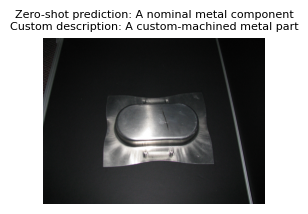


Key Takeaway: The results show that with zero-shot classification, the CLIP model was
unable to identify this image as a simulated defective part. This limitation suggests
that the model may require additional labeled examples to improve its understanding of
such domain-specific scenarios.


In [9]:
# Load and preprocess an example image
image_path = "https://github.com/fmegahed/qe_genai/raw/main/data/pan_images/train/defective/IMG_1572.JPG"
image = load_image(image_path)
preprocessed_image = preprocess(image).unsqueeze(0).to(device)

# (A) Show the embedding size
np.set_printoptions(precision=4, suppress=True)  # Set precision and suppress scientific notation

with torch.no_grad():
    image_features = model.encode_image(preprocessed_image)
    print(f"\n\033[1mImage size:\033[0m {image.size}")
    print(f"\n\033[1mEmbedding size:\033[0m {image_features.shape},")
    print(
    "where the first dimension corresponds to the \033[1m number of passed images\033[0m, \n"
    "and the second dimension corresponds to the size of the \033[1mfeature vector\033[0m \n"
    "produced by the specific CLIP model variant."
    )

    # Display the first 5 and last 5 elements of the embedding tensor
    embedding_array = image_features.cpu().numpy().flatten()
    first_5 = embedding_array[:5]
    last_5 = embedding_array[-5:]
    print(f"\n\033[1mEmbedding (Tensor of size {image_features.shape[1]}):\033[0m [{', '.join(f'{x:.4f}' for x in first_5)}, ..., {', '.join(f'{x:.4f}' for x in last_5)}]")

# (B) Zero-shot prediction
# Define a set of captions for zero-shot classification
captions = [
    "A defective metal component",
    "A nominal metal component",
    "An industrial part",
    "A piece of sheet metal",
    "An artistic photograph"
]
text_inputs = clip.tokenize(captions).to(device)
print(f"\n\033[1mCaption size:\033[0m {text_inputs.shape}")

# Compute text and image embeddings
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # Print text embeddings
    print(f"\n\033[1mText embedding size:\033[0m {text_features.shape}")
    # Print text embeddings
    print("\n\033[1mText Embeddings (first 5 captions):\033[0m")
    for i, caption in enumerate(captions[:5]):
        text_embedding = text_features[i].cpu().numpy().flatten()  # Get the embedding for each caption
        print(f"Caption: {caption}")
        print(f"Embedding: [{', '.join(f'{x:.4f}' for x in text_embedding[:5])}, ..., {', '.join(f'{x:.4f}' for x in text_embedding[-5:])}]\n")

    # Compute similarities and probabilities
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # Print the probabilities for each label
    print("\n\033[1mLabel Probabilities:\033[0m")
    for caption, prob in zip(captions, similarity.squeeze().tolist()):
        print(f"{caption}: {prob:.4f}")

    # Get the prediction
    prediction = captions[similarity.argmax()]
    print(f"\n\033[1mZero-shot prediction:\033[0m {prediction}")

# (C) Illustrate text-image alignment
# Define custom descriptive captions
custom_captions = [
    "A metallic surface with a simulated scratch done by a black marker",
    "A perfect metal sheet",
    "A manufacturing defect",
    "A custom-machined metal part",
    "A flat industrial surface"
]
custom_text_inputs = clip.tokenize(custom_captions).to(device)

# Compute similarity for custom descriptions
with torch.no_grad():
    custom_text_features = model.encode_text(custom_text_inputs)
    custom_text_features /= custom_text_features.norm(dim=-1, keepdim=True)
    custom_similarity = (100.0 * image_features @ custom_text_features.T).softmax(dim=-1)

# Display the custom description with the highest similarity
custom_prediction = custom_captions[custom_similarity.argmax()]
print(f"\n\033[1mCustom description:\033[0m {custom_prediction}")

plt.figure(figsize=(0.45 * plt.rcParams["figure.figsize"][0],
                    0.45 * plt.rcParams["figure.figsize"][1]))
plt.imshow(image)
plt.axis("off")
plt.title(f"Zero-shot prediction: {prediction}\nCustom description: {custom_prediction}", fontsize=8)
plt.show()

print(
    "\n\033[1mKey Takeaway:\033[0m The results show that with zero-shot classification, the CLIP model was\n"
    "unable to identify this image as a simulated defective part. This limitation suggests\n"
    "that the model may require additional labeled examples to improve its understanding of\n"
    "such domain-specific scenarios."
)

# 4.&nbsp; Experiment 1: The Metalic Pans

Here, we focus on evaluating our fault detection methodology using experimental data from [Megahed and Camelio (2012)](https://doi.org/10.1007/s10845-010-0378-3). We utilized their training dataset comprising 10 nominal and 10 defective images, alongside their testing dataset consisting of 50 nominal images and 50 defective images.  Our experiment aims to examine whether levarging few-shot learning with CLIP can effectively eliminate the need for users to engage in traditional image processing and complex/customized analysis, which would simplify the process of inspecting the quality of industrial products.

For ease of access and reproducibility, all relevant images have been uploaded to our GitHub repository to further simplify the reproducibility of our experiment.  

## 4.1. Extracting the Images from the GitHub Repo

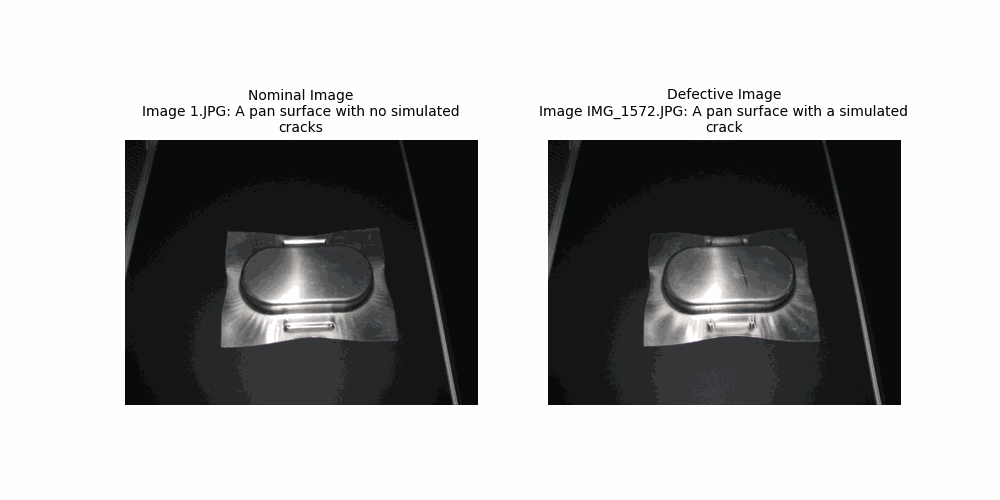

In [10]:
# Set the GitHub repository details
repo_owner = "fmegahed"
repo_name = "qe_genai"
base_path = "data/pan_images/train"

# Retrieve URLs for each subfolder
nominal_image_urls = get_image_urls(repo_owner, repo_name, base_path, "nominal")
defective_image_urls = get_image_urls(repo_owner, repo_name, base_path, "defective")

# Extract filenames for descriptions
nominal_image_filenames = [url.split('/')[-1] for url in nominal_image_urls]
defective_image_filenames = [url.split('/')[-1] for url in defective_image_urls]

# Descriptions for each nominal image
nominal_descriptions = [
    f"Image {filename}: A pan surface with no simulated cracks"
    for filename in nominal_image_filenames
]

# Fault descriptions for each defective image
defective_descriptions = [
    f"Image {filename}: A pan surface with a simulated crack"
    for filename in defective_image_filenames
]

# Load nominal (good) and faulty images from GitHub
nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in nominal_image_urls]
defective_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in defective_image_urls]

# Load the test images
base_path = "data/pan_images/test"

test_nominal_image_urls = get_image_urls(repo_owner, repo_name, base_path, "nominal")
test_defective_image_urls = get_image_urls(repo_owner, repo_name, base_path, "defective")
test_image_urls = test_nominal_image_urls + test_defective_image_urls

test_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_image_urls]

# Create a GIF of animated images
animate_images(
    nominal_image_urls=nominal_image_urls,
    nominal_labels=nominal_descriptions,
    defective_image_urls=defective_image_urls,
    defective_labels=defective_descriptions,
    resize_factor=0.15,
    pause_time=2.0,
    save_fig=True,
    file_path=save_folder,
    file_name="exp01_training_images.gif"
)

display(IPyImage(filename=f"{save_folder}/exp01_training_images.gif"))


## 4.2. Few-Shot Classification with CLIP

In [11]:
classification_results = few_shot_fault_classification(
    test_images = test_images,
    test_image_filenames = [url.split('/')[-1] for url in test_image_urls],
    nominal_images = nominal_images,
    nominal_descriptions = nominal_descriptions,
    defective_images = defective_images,
    defective_descriptions = defective_descriptions,
    nominal_train_size = len(nominal_images),
    file_path = save_folder,
    file_name = 'exp01_results.csv',
    print_one_liner = False
)

## 4.3. Computing the Classification Performance


Confusion Matrix for Experiment 01: Inspecting Pan Images


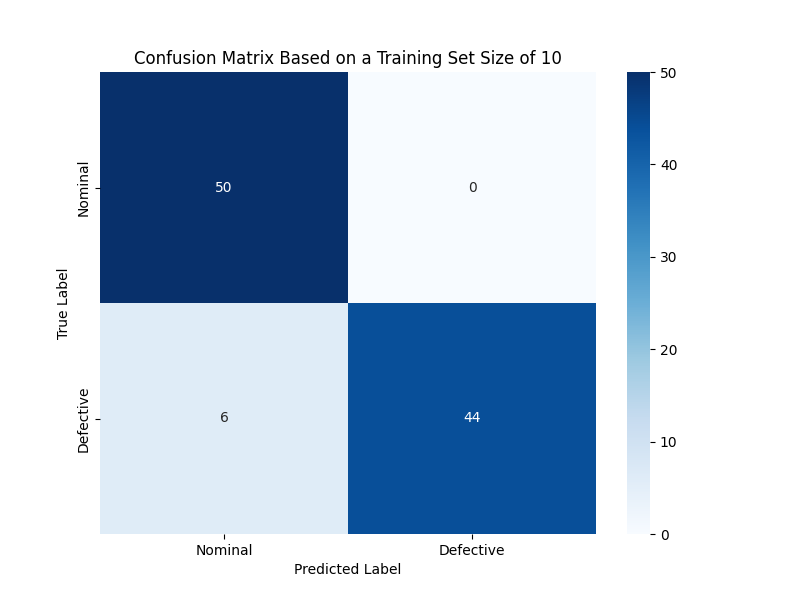


Classification Metrics:


,Metric,Value,megahed_camelio_benchmark,improvement
0,Accuracy,0.940,0.880,0.060
1,Sensitivity (Recall),0.880,0.760,0.120
2,Specificity,1.000,1.000,0.000
3,Precision,1.000,1.000,0.000
4,F1 Score,0.936,0.857,0.079
5,AUC,0.999,NaN,NaN


In [12]:
# Computing the classification metrics
classification_metrics = compute_classification_metrics(
    csv_file = f'{save_folder}/exp01_results.csv',
    labels = ["Nominal", "Defective"],
    label_counts = [len(test_nominal_image_urls), len(test_defective_image_urls)],
    nominal_train_size = len(nominal_images),
    save_confusion_matrix = True,
    cm_file_path = save_folder,
    cm_file_name = "exp01_confusion_matrix.png"
    )

# Rounding for display
classification_metrics.Value = classification_metrics.Value.round(3)

# Comparing with Megahed and Camelio benchmark
classification_metrics = classification_metrics.assign(
    megahed_camelio_benchmark = [10, 0.880, 0.760, 1.000, 1.000, 0.857, np.nan],
    improvement = lambda x: x.Value - x.megahed_camelio_benchmark
)

# Drop the row corresponding to nominal_train_size since it is not a classification metric
classification_metrics = classification_metrics.drop(index=0).reset_index(drop=True)

# Display the created confusion metrics figure
print("\n\033[1mConfusion Matrix for Experiment 01: Inspecting Pan Images\033[1m")
display(IPyImage(filename=f"{save_folder}/exp01_confusion_matrix.png"))

# Display the metrics as a table with three digit precision
print("\n\033[1mClassification Metrics:\033[1m")
display(classification_metrics)

# 5.&nbsp; Experiment 2: Extrusion Classification

**Hongyue to add explanations for this dataset.**

## 5.1. Extracting the Images from our GitHub Repo

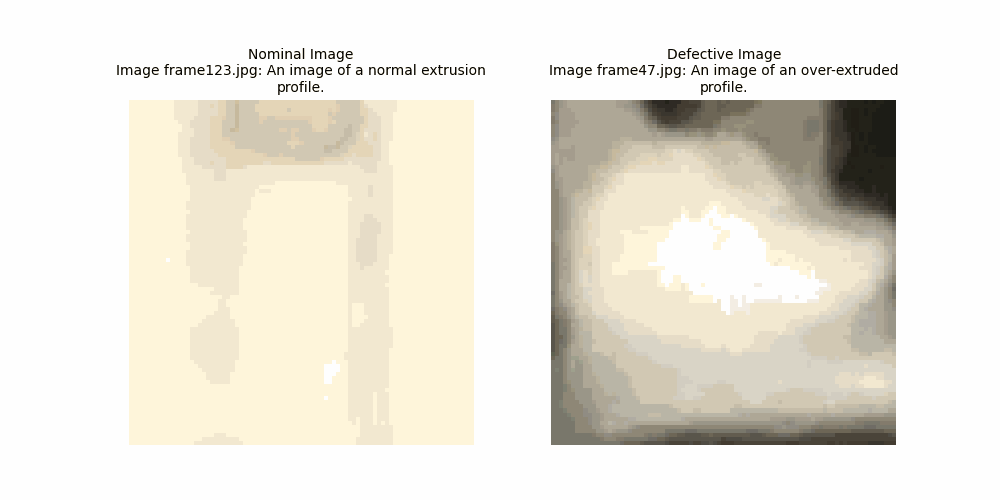

In [13]:
import random

# Set the GitHub repository details
repo_owner = "fmegahed"
repo_name = "qe_genai"
base_path = "data/extrusion_images"

# Retrieve URLs for each subfolder
nominal_image_urls = get_image_urls(repo_owner, repo_name, base_path, "normal")
defective_over_image_urls = get_image_urls(repo_owner, repo_name, base_path, "over")
defective_under_image_urls = get_image_urls(repo_owner, repo_name, base_path, "under")

# Set seed for reproducibility
random.seed(2024)

# Step 1: Select Test Set
# Set test set size
test_size = 100
test_nominal_image_urls = random.sample(nominal_image_urls, test_size)
test_defective_over_image_urls = random.sample(defective_over_image_urls, int(test_size / 2))
test_defective_under_image_urls = random.sample(defective_under_image_urls, int(test_size / 2))

# Combine defective test set
test_defective_image_urls = test_defective_over_image_urls + test_defective_under_image_urls

# Step 2: Create Lists of Remaining Images
# Remove test images from original lists
remaining_nominal_image_urls = [url for url in nominal_image_urls if url not in test_nominal_image_urls]
remaining_defective_over_image_urls = [url for url in defective_over_image_urls if url not in test_defective_over_image_urls]
remaining_defective_under_image_urls = [url for url in defective_under_image_urls if url not in test_defective_under_image_urls]

# Extract test image filenames
test_nominal_image_filenames = [url.split('/')[-1] for url in test_nominal_image_urls]
test_defective_over_filenames = [url.split('/')[-1] for url in test_defective_over_image_urls]
test_defective_under_filenames = [url.split('/')[-1] for url in test_defective_under_image_urls]
test_image_filenames = test_nominal_image_filenames + test_defective_over_filenames + test_defective_under_filenames

# Step 3: Shuffle Lists
random.shuffle(remaining_nominal_image_urls)
random.shuffle(remaining_defective_over_image_urls)
random.shuffle(remaining_defective_under_image_urls)

# Step 4: Select Training Set
# Define desired training size
train_size = 20 # We can adjust this
train_nominal_image_urls = remaining_nominal_image_urls[:train_size]
train_defective_over_image_urls = remaining_defective_over_image_urls[:int(train_size / 2)]
train_defective_under_image_urls = remaining_defective_under_image_urls[:int(train_size / 2)]

# Combine defective training set
train_defective_image_urls = train_defective_over_image_urls + train_defective_under_image_urls

# Extract filenames if needed for descriptions
train_nominal_image_filenames = [url.split('/')[-1] for url in train_nominal_image_urls]
train_defective_over_filenames = [url.split('/')[-1] for url in train_defective_over_image_urls]
train_defective_under_filenames = [url.split('/')[-1] for url in train_defective_under_image_urls]

# Descriptions for training images
nominal_descriptions = [
    f"Image {filename}: An image of a normal extrusion profile."
    for filename in train_nominal_image_filenames
]
over_descriptions = [
    f"Image {filename}: An image of an over-extruded profile."
    for filename in train_defective_over_filenames
]
under_descriptions = [
    f"Image {filename}: An image of an under-extruded profile."
    for filename in train_defective_under_filenames
]
defective_descriptions = over_descriptions + under_descriptions

# Loading the training images from GitHub
nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_nominal_image_urls]
over_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_defective_over_image_urls]
under_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_defective_under_image_urls]
defective_images = over_images + under_images

# Load the testing images from GitHub
test_nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_nominal_image_urls]
test_over_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_defective_over_image_urls]
test_under_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_defective_under_image_urls]
test_defective_images = test_over_images + test_under_images

# Create a GIF of animated images for the training data
animate_images(
    nominal_image_urls=train_nominal_image_urls,
    nominal_labels=nominal_descriptions,
    defective_image_urls=train_defective_image_urls,
    defective_labels=defective_descriptions,
    resize_factor=1,
    pause_time=2.0,
    save_fig=True,
    file_path=save_folder,
    file_name="exp02_training_images.gif"
)

display(IPyImage(filename=f"{save_folder}/exp02_training_images.gif"))


## 5.2. Few-Shot Classification with CLIP

In [14]:
classification_results = few_shot_fault_classification(
    test_images = (test_nominal_images + test_defective_images),
    test_image_filenames = [url.split('/')[-1] for url in (test_nominal_image_urls + test_defective_image_urls)],
    nominal_images = nominal_images,
    nominal_descriptions = nominal_descriptions,
    defective_images = defective_images,
    defective_descriptions = defective_descriptions,
    nominal_train_size = len(nominal_images),
    file_path = save_folder,
    file_name = 'exp02_results.csv',
    print_one_liner = False
)

## 5.3. Computing the Classification Performance


Confusion Matrix for Experiment 02: Inspecting Extrusion Images


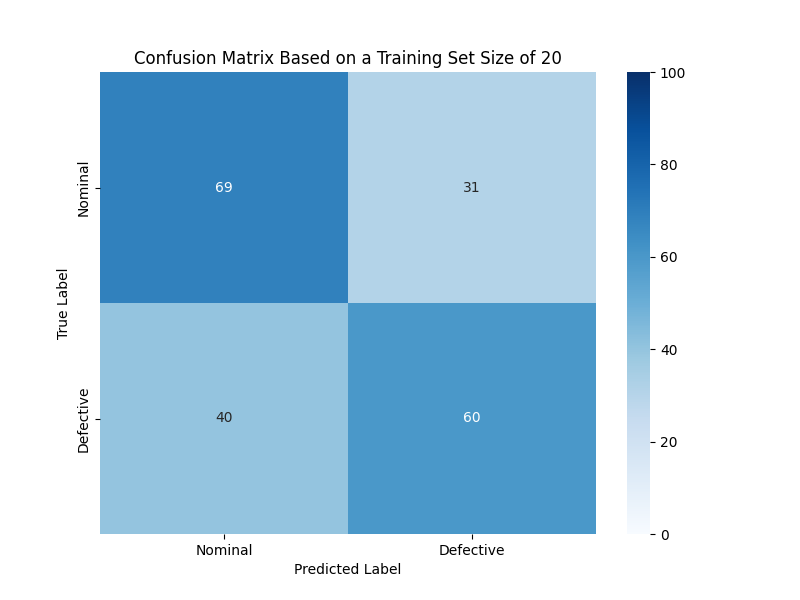


Classification Metrics:


,Metric,Value
0,Accuracy,0.645
1,Sensitivity (Recall),0.600
2,Specificity,0.690
3,Precision,0.659
4,F1 Score,0.628
5,AUC,0.682


In [15]:
classification_metrics = compute_classification_metrics(
    csv_file = f'{save_folder}/exp02_results.csv',
    labels = ["Nominal", "Defective"],
    label_counts = [len(test_nominal_image_urls), len(test_defective_image_urls)],
    nominal_train_size = len(nominal_images),
    save_confusion_matrix = True,
    cm_file_path = save_folder,
    cm_file_name = "exp02_confusion_matrix.png"
    )

# Rounding for display
classification_metrics.Value = classification_metrics.Value.round(3)

# Drop the row corresponding to nominal_train_size since it is not a classification metric
classification_metrics = classification_metrics.drop(index=0).reset_index(drop=True)

# Display the created confusion metrics figure
print("\n\033[1mConfusion Matrix for Experiment 02: Inspecting Extrusion Images\033[1m")
display(IPyImage(filename=f"{save_folder}/exp02_confusion_matrix.png"))

# Display the metrics as a table with three digit precision
print("\n\033[1mClassification Metrics:\033[1m")
display(classification_metrics)

## 5.4. Varying the Train Size

In [16]:
# Preloading the Images for Training:
# -----------------------------------
test_images = (test_nominal_images + test_defective_images)

train_nominal_image_filenames = [url.split('/')[-1] for url in remaining_nominal_image_urls]
train_defective_over_filenames = [url.split('/')[-1] for url in remaining_defective_over_image_urls]
train_defective_under_filenames = [url.split('/')[-1] for url in remaining_defective_under_image_urls]

# Descriptions for training images
nominal_descriptions = [
    f"Image {filename}: An image of a normal extrusion profile."
    for filename in train_nominal_image_filenames
]
over_descriptions = [
    f"Image {filename}: An image of an over-extruded profile."
    for filename in train_defective_over_filenames
]
under_descriptions = [
    f"Image {filename}: An image of an under-extruded profile."
    for filename in train_defective_under_filenames
]
defective_descriptions = over_descriptions + under_descriptions

# Loading the training images from GitHub
nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_nominal_image_urls]
over_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_defective_over_image_urls]
under_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_defective_under_image_urls]
defective_images = over_images + under_images

# Running the Function:
# ---------------------
vary_training_set(
    train_grid = [10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 350],
    nominal_images = nominal_images,
    defect_dict={
    "over": over_images,
    "under": under_images
    },
    test_images= test_images,
    test_image_filenames=test_image_filenames,
    nominal_descriptions=nominal_descriptions,
    defect_descriptions={
    "over": over_descriptions,
    "under": under_descriptions
    },
    equal_train_size=True,
    defect_train_size=50,  # Ignored if equal_train_size=True
    save_folder=save_folder,
    prefix="exp02",  # Prefix for saved CSV and PNG file names
    labels=["Nominal", "Defective"],  # Labels for classification
    label_counts=[len(test_nominal_images), len(test_defective_images)]  # Number of test samples per class
)

### 5.4.1. Visualizing the Confusion Matrices

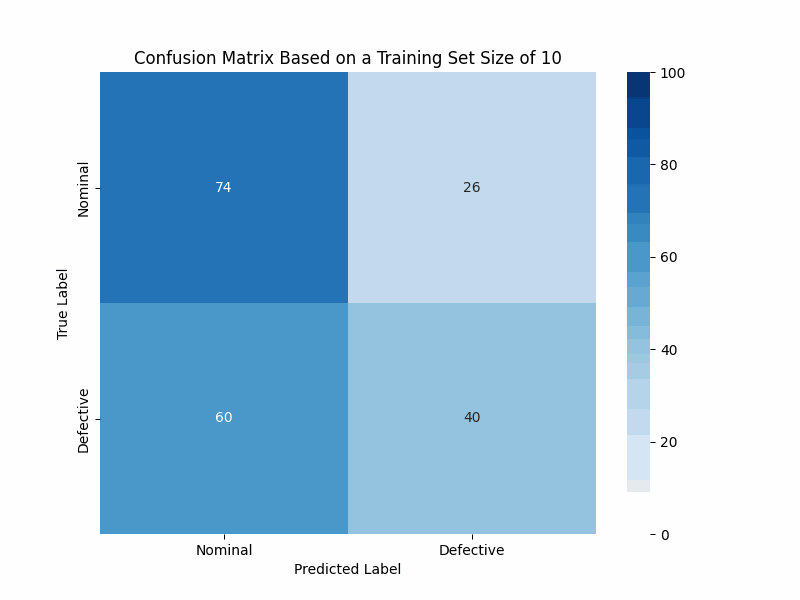

In [17]:
create_confusion_matrix_gif(
    prefix="exp02_conf_matrix",
    train_size=[10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 350],
    duration=3000,
    save_folder=save_folder,
    file_save_name= "exp02_conf_matrices_all.gif"
)

### 5.4.2. Visualizing the Impact of Training Size on Classification Metrics

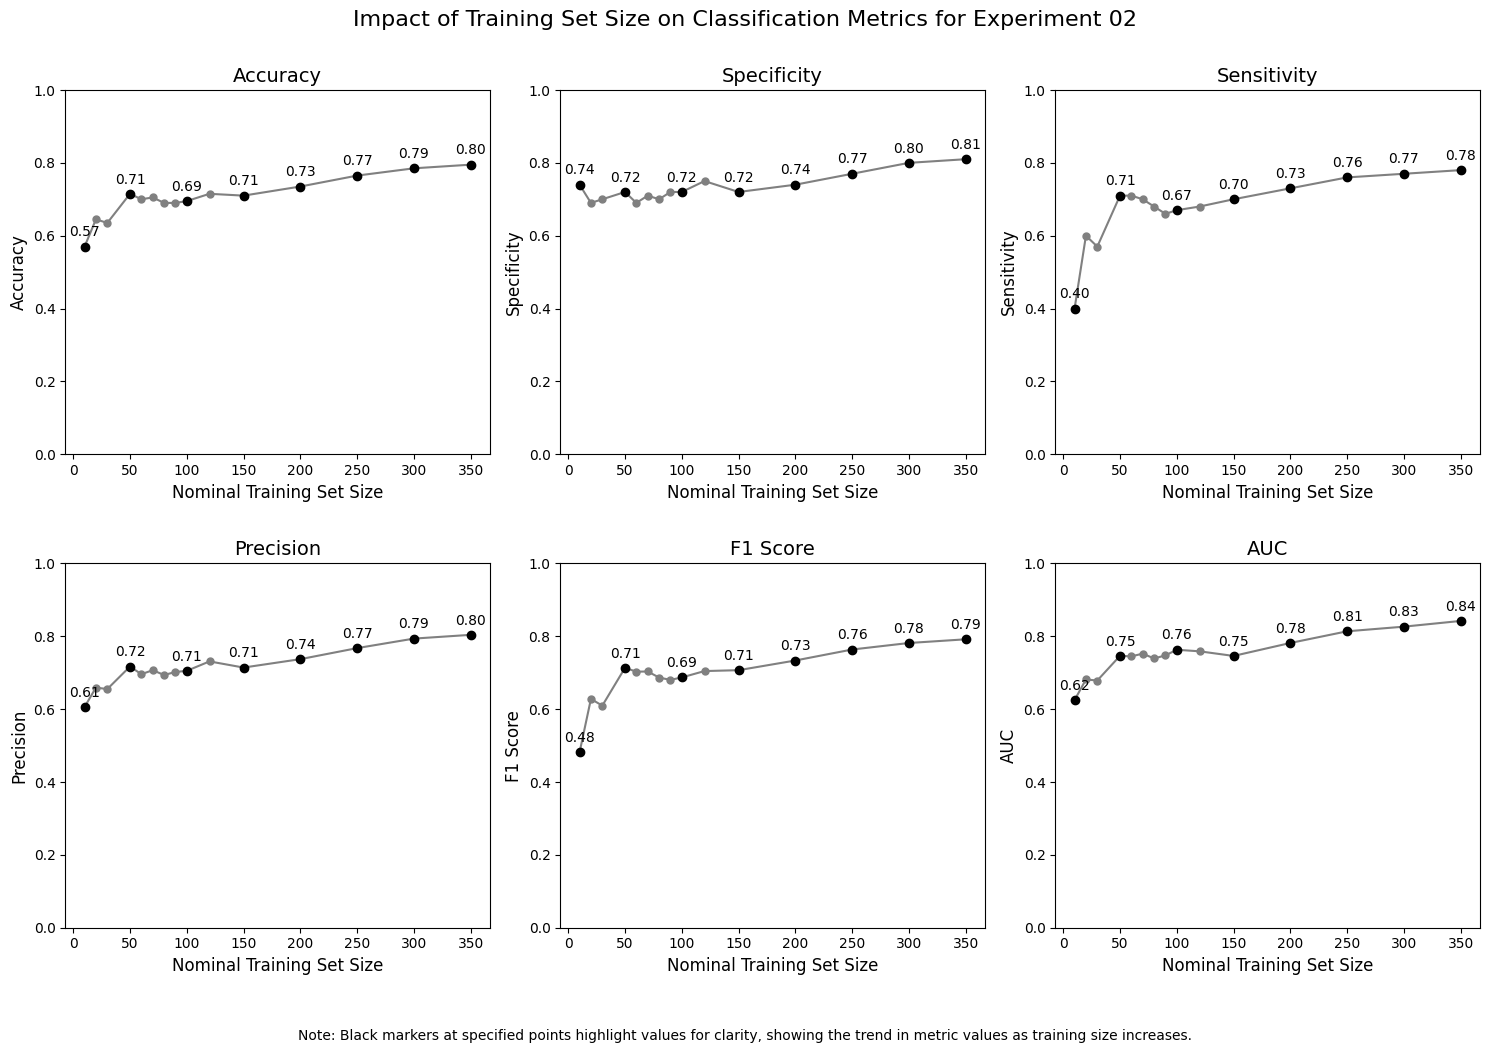

In [18]:
raw_results = pd.read_csv(f"{save_folder}/exp02_aggregated_results.csv")
preprocess_and_plot_training_size_metrics(
    raw_data=raw_results,
    save_folder=save_folder,
    save_file_name="exp02_training_size_metrics.png",
    y_limits=[0, 1],
    label_positions={10, 50, 100, 150, 200, 250, 300, 350},
    suptitle="Impact of Training Set Size on Classification Metrics for Experiment 02",
    figure_size=(15, 10)
)


# 6.&nbsp; Experiment 3: Stochastic Textured Surfaces

## 6.1. Extracting the Images from our GitHub Repo

In [20]:
import random

# Set the GitHub repository details
repo_owner = "fmegahed"
repo_name = "qe_genai"
base_path = "data/textile_images/simulated"

# Retrieve URLs for each subfolder
nominal_image_urls = get_image_urls(repo_owner, repo_name, base_path, "nominal")
defective_local_image_urls = get_image_urls(repo_owner, repo_name, base_path, "local")
defective_global_image_urls = get_image_urls(repo_owner, repo_name, base_path, "global")

# Set seed for reproducibility
random.seed(2024)

# Step 1: Select Test Set
# Set test set size
test_size = 100
test_nominal_image_urls = random.sample(nominal_image_urls, test_size)
test_defective_global_image_urls = random.sample(defective_global_image_urls, int(test_size / 2))
test_defective_local_image_urls = random.sample(defective_local_image_urls, int(test_size / 2))

# Combine defective test set
test_defective_image_urls = test_defective_global_image_urls + test_defective_local_image_urls

# Step 2: Create Lists of Remaining Images
# Remove test images from original lists
remaining_nominal_image_urls = [url for url in nominal_image_urls if url not in test_nominal_image_urls]
remaining_defective_global_image_urls = [url for url in defective_global_image_urls if url not in test_defective_global_image_urls]
remaining_defective_local_image_urls = [url for url in defective_local_image_urls if url not in test_defective_local_image_urls]

# Extract test image filenames
test_nominal_image_filenames = [url.split('/')[-1] for url in test_nominal_image_urls]
test_defective_global_filenames = [url.split('/')[-1] for url in test_defective_global_image_urls]
test_defective_local_filenames = [url.split('/')[-1] for url in test_defective_local_image_urls]
test_image_filenames = test_nominal_image_filenames + test_defective_global_filenames + test_defective_local_filenames

# Step 3: Shuffle Lists
random.shuffle(remaining_nominal_image_urls)
random.shuffle(remaining_defective_global_image_urls)
random.shuffle(remaining_defective_local_image_urls)

# Step 4: Select Training Set
# Define desired training size
train_size = 20 # We can adjust this
train_nominal_image_urls = remaining_nominal_image_urls[:train_size]
train_defective_global_image_urls = remaining_defective_global_image_urls[:int(train_size / 2)]
train_defective_local_image_urls = remaining_defective_local_image_urls[:int(train_size / 2)]

# Combine defective training set
train_defective_image_urls = train_defective_global_image_urls + train_defective_local_image_urls

# Extract filenames if needed for descriptions
train_nominal_image_filenames = [url.split('/')[-1] for url in train_nominal_image_urls]
train_defective_global_filenames = [url.split('/')[-1] for url in train_defective_global_image_urls]
train_defective_local_filenames = [url.split('/')[-1] for url in train_defective_local_image_urls]

# Descriptions for training images
nominal_descriptions = [
    f"Image {filename}: An image of a textile material with consistent weave patterns, showing no visible defects or irregularities."
    for filename in train_nominal_image_filenames
]
global_descriptions = [
    f"Image {filename}: A textile pattern with a slight overall distortion from our baseline textile, causing a uniform shift across the entire surface."
    for filename in train_defective_global_filenames
]
local_descriptions = [
    f"Image {filename}: An image of a textile material with a small localized defect, disrupting the otherwise consistent weave pattern."
    for filename in train_defective_local_filenames
]
defective_descriptions = global_descriptions + local_descriptions

# Loading the training images from GitHub
nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_nominal_image_urls]
global_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_defective_global_image_urls]
local_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in train_defective_local_image_urls]
defective_images = global_images + local_images

# Load the testing images from GitHub
test_nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_nominal_image_urls]
test_global_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_defective_global_image_urls]
test_local_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in test_defective_local_image_urls]
test_defective_images = test_global_images + test_local_images

# Create a GIF of animated images for the training data
animate_images(
    nominal_image_urls=train_nominal_image_urls,
    nominal_labels=nominal_descriptions,
    defective_image_urls=train_defective_image_urls,
    defective_labels=defective_descriptions,
    resize_factor=1,
    pause_time=2.0,
    save_fig=True,
    file_path=save_folder,
    file_name="exp03_training_images.gif"
)

display(IPyImage(filename=f"{save_folder}/exp03_training_images.gif"))


Output hidden; open in https://colab.research.google.com to view.

## 6.2. Varying the Train Size

In [21]:
# Preloading the Images for Training:
# -----------------------------------
test_images = (test_nominal_images + test_defective_images)

train_nominal_image_filenames = [url.split('/')[-1] for url in remaining_nominal_image_urls]
train_defective_global_filenames = [url.split('/')[-1] for url in remaining_defective_global_image_urls]
train_defective_local_filenames = [url.split('/')[-1] for url in remaining_defective_local_image_urls]

# Descriptions for training images
nominal_descriptions = [
    f"Image {filename}: An image of a textile material with consistent weave patterns, showing no visible defects or irregularities."
    for filename in train_nominal_image_filenames
]
global_descriptions = [
    f"Image {filename}: A textile pattern with a slight overall distortion from our baseline textile, causing a uniform shift across the entire surface."
    for filename in train_defective_global_filenames
]
local_descriptions = [
    f"Image {filename}: An image of a textile material with a small localized defect, disrupting the otherwise consistent weave pattern."
    for filename in train_defective_local_filenames
]
defective_descriptions = global_descriptions + local_descriptions

# Loading the training images from GitHub
nominal_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_nominal_image_urls]
global_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_defective_global_image_urls]
local_images = [preprocess(load_image(url)).unsqueeze(0).to(device) for url in remaining_defective_local_image_urls]
defective_images = global_images + local_images

# Running the Function:
# ---------------------
vary_training_set(
    train_grid = [10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 350],
    nominal_images = nominal_images,
    defect_dict={
    "global": global_images,
    "local": local_images
    },
    test_images= test_images,
    test_image_filenames=test_image_filenames,
    nominal_descriptions=nominal_descriptions,
    defect_descriptions={
    "global": global_descriptions,
    "local": local_descriptions
    },
    equal_train_size=True,
    defect_train_size=50,  # Ignored if equal_train_size=True
    save_folder=save_folder,
    prefix="exp03",  # Prefix for saved CSV and PNG file names
    labels=["Nominal", "Defective"],  # Labels for classification
    label_counts=[len(test_nominal_images), len(test_defective_images)]  # Number of test samples per class
)

### 6.2.1. Visualizing the Confusion Matrices

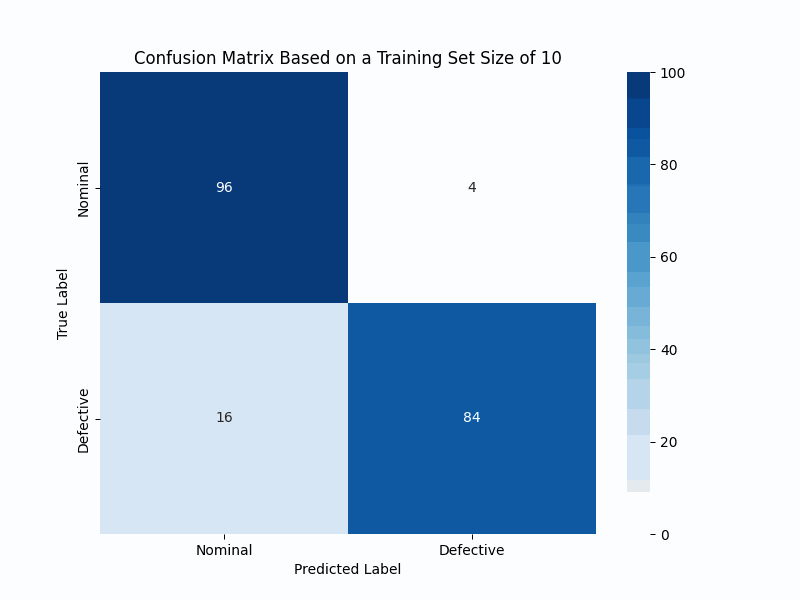

In [22]:
create_confusion_matrix_gif(
    prefix="exp03_conf_matrix",
    train_size=[10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 350],
    duration=3000,
    save_folder=save_folder,
    file_save_name= "exp03_conf_matrices_all.gif"
)

### 6.2.2. Visualizing the Impact of Training Size on Classification Metrics

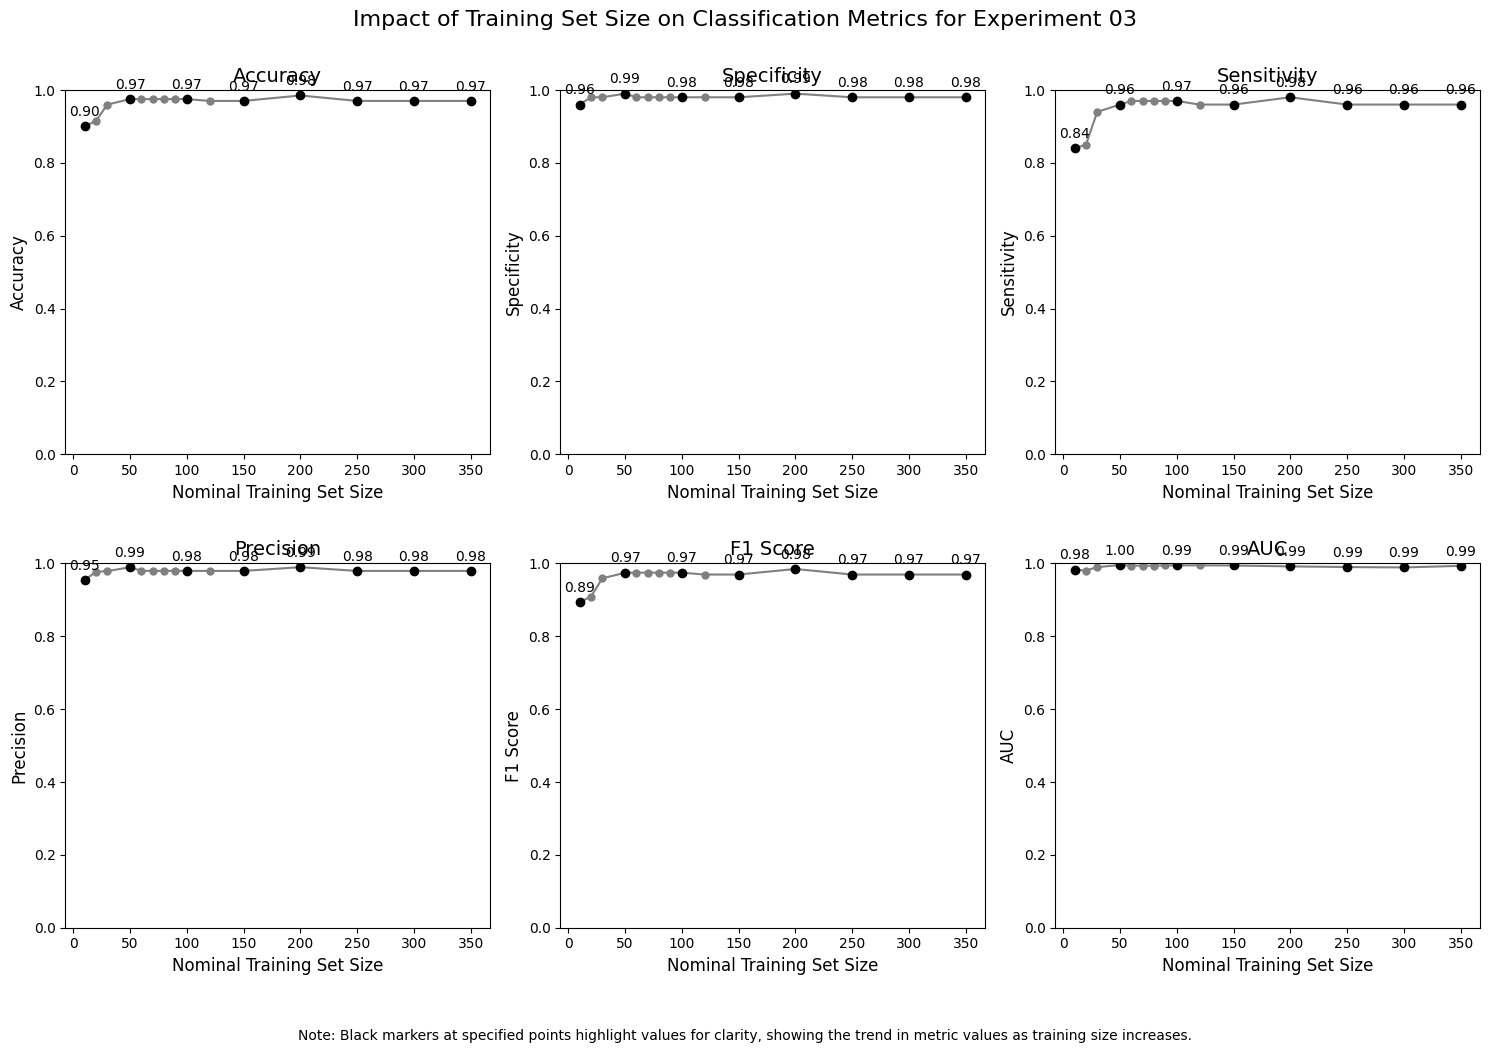

In [23]:
raw_results = pd.read_csv(f"{save_folder}/exp03_aggregated_results.csv")
preprocess_and_plot_training_size_metrics(
    raw_data=raw_results,
    save_folder=save_folder,
    save_file_name="exp03_training_size_metrics.png",
    y_limits=[0, 1],
    label_positions={10, 50, 100, 150, 200, 250, 300, 350},
    suptitle="Impact of Training Set Size on Classification Metrics for Experiment 03",
    figure_size=(15, 10)
)
